In [1]:
# Установка необходимых библиотек
!pip install shap
!pip install catboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor  # Импорт CatBoostRegressor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.2 MB/s eta 0:00:00


In [2]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer #для создания авторских метрик
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


               Model       MSE      RMSE        R2
0  Linear Regression  5.860806  2.420910  0.365184
1              Ridge  5.176660  2.275227  0.439288
2              Lasso  9.266307  3.044061 -0.003684
3         ElasticNet  9.266307  3.044061 -0.003684
4      Random Forest  0.157942  0.397419  0.982892
5            Bagging  0.159683  0.399603  0.982704
6           CatBoost  0.036988  0.192323  0.995994


<ipython-input-3-9f2baef8fb1f>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(df_results["Model"], rotation=45, ha="right")
<ipython-input-3-9f2baef8fb1f>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(df_results["Model"], rotation=45, ha="right")
<ipython-input-3-9f2baef8fb1f>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(df_results["Model"], rotation=45, ha="right")


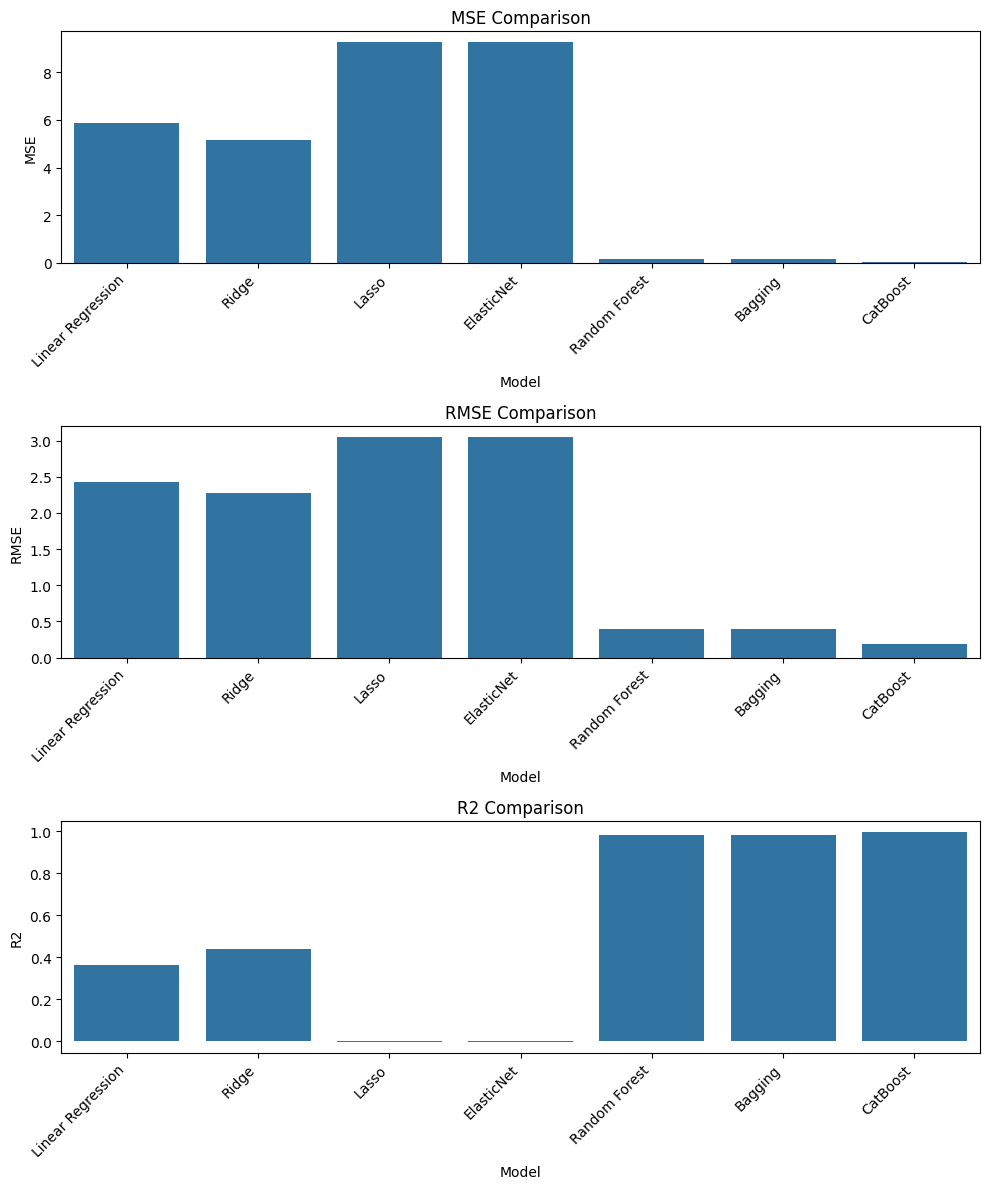

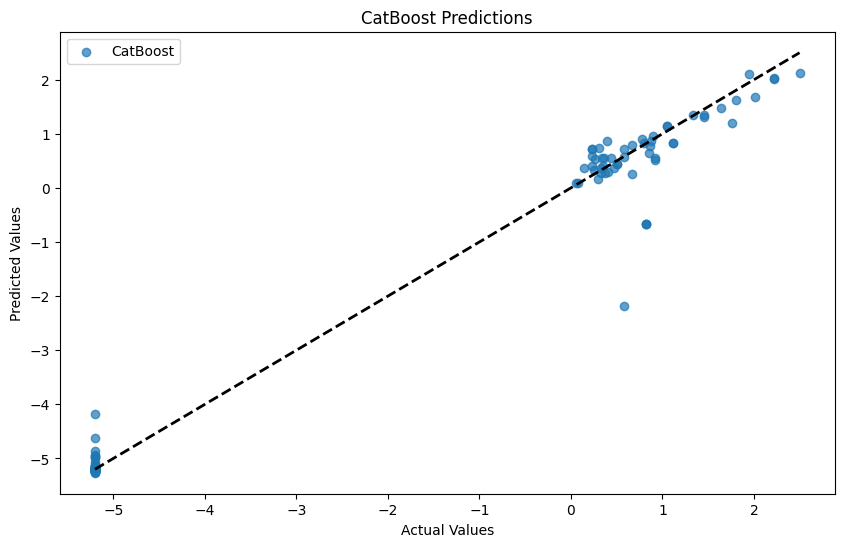

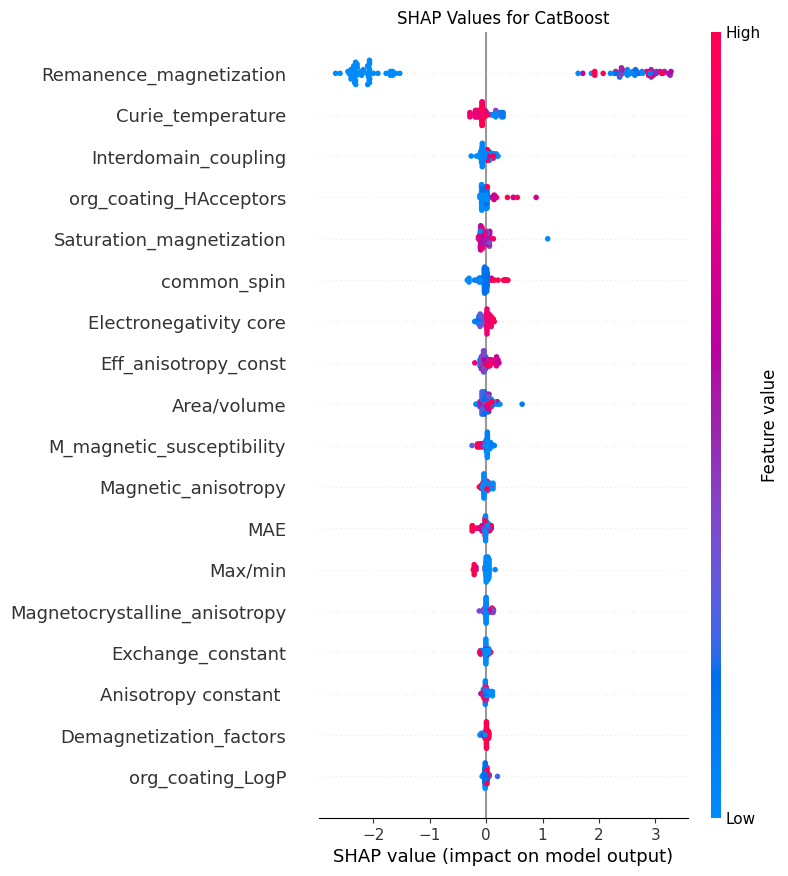

In [3]:
# Чтение данных
df = pd.read_csv('/content/Distr_data_0202_last.csv')

# Преобразование категориальных признаков
category_list = ['Spehricity', 'Crystalline', 'Space group']
df[category_list] = df[category_list].astype('category')

# Удаление лишних столбцов
df = df.drop(columns=['Spehricity', 'Crystalline', 'Space group'])

# Разделение на признаки и целевую переменную
X = df.drop('Coercivity', axis=1)
y = df['Coercivity']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание моделей для сравнения, включая CatBoost
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Bagging": BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=100, random_state=42),
    "CatBoost": CatBoostRegressor(iterations=100, random_state=42, logging_level='Silent')  # Добавление CatBoost
}

# Обучение и оценка моделей
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results.append({"Model": name, "MSE": mse, "RMSE": rmse, "R2": r2})

# Вывод результатов
df_results = pd.DataFrame(results)
print(df_results)

# Визуализация результатов
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

for i, metric in enumerate(["MSE", "RMSE", "R2"]):
    sns.barplot(x="Model", y=metric, data=df_results, ax=axes[i])
    axes[i].set_title(f"{metric} Comparison")
    axes[i].set_ylabel(metric)
    axes[i].set_xticklabels(df_results["Model"], rotation=45, ha="right")

plt.tight_layout()
plt.show()

# Оптимизация гиперпараметров для CatBoost
param_grid_catboost = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1]
}

grid_search_catboost = GridSearchCV(CatBoostRegressor(random_state=42, logging_level='Silent'), param_grid_catboost, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_catboost.fit(X_train, y_train)

best_catboost_model = grid_search_catboost.best_estimator_
best_catboost_model.fit(X_train, y_train)

# Визуализация предсказаний CatBoost
plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_catboost_model.predict(X_test), label='CatBoost', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('CatBoost Predictions')
plt.legend()
plt.show()

# Визуализация SHAP для CatBoost
shap_values_catboost = shap.TreeExplainer(best_catboost_model).shap_values(X_test)
shap.summary_plot(shap_values_catboost, X_test, feature_names=X_test.columns, show=False)
plt.title('SHAP Values for CatBoost')
plt.show()